## Duma Vitalii

In [1]:
import operator
import seaborn as sns
import pandas as pd
from collections import defaultdict
import geopandas
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./master.csv')

In [3]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


### Data cleaning

In [4]:
df['suicides'] = df['suicides/100k pop']
df['gdp_per_capita'] = df['gdp_per_capita ($)']

In [5]:
total = sorted(list(df.groupby('country')['suicides'].sum().to_dict().items()), key=operator.itemgetter(1))
total[0:5]

[('Dominica', 0.0),
 ('Saint Kitts and Nevis', 0.0),
 ('Oman', 26.5),
 ('United Arab Emirates', 94.88999999999997),
 ('Jamaica', 106.44)]

#### Dominica and Saint Kitts and Nevis will be deleted from dataset because no suicide data is provided

In [6]:
df = df[(df['country'] != 'Dominica') & (df['country'] != 'Saint Kitts and Nevis')]

In [7]:
country_years_data = sorted(
    list((df.groupby('country')['year'].count()/12).to_dict().items()), key=operator.itemgetter(1)
)[0:15]
country_years_data

[('Mongolia', 0.8333333333333334),
 ('Cabo Verde', 1.0),
 ('Macau', 1.0),
 ('Bosnia and Herzegovina', 2.0),
 ('Oman', 3.0),
 ('San Marino', 3.0),
 ('Nicaragua', 6.0),
 ('United Arab Emirates', 6.0),
 ('Turkey', 7.0),
 ('Maldives', 10.0),
 ('Montenegro', 10.0),
 ('Fiji', 11.0),
 ('Kiribati', 11.0),
 ('Sri Lanka', 11.0),
 ('Aruba', 14.0)]

#### There are 6 countries with less than 3 years suicide reports. Remove them

In [8]:
df = df[~df.country.isin([country[0] for country in country_years_data[0:6]])]

### Global suicides visualization

#### Take a look at the world map of suicides

In [9]:
# Calculate mean suicides rate for every country/year
suicides_country_year = df.groupby(['country', 'year'])['suicides'].mean()


country_latest_year = defaultdict(int)
country_latest_suicides = {}

# Find the most recent data for each country
for (country, year), suicides in suicides_country_year.items():
    if year > country_latest_year[country] and suicides:
        country_latest_year[country] = year
        country_latest_suicides[country] = suicides

In [10]:
# Initialize world map without Antarctica
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[world.name!="Antarctica"]

# Countries 
countries_dict = {
    'Czechia':'Czech Republic',
    'South Korea': 'Republic of Korea',
    'Russia': 'Russian Federation',
    'United States of America': 'United States',
}

world['suicides'] = world.name.map(
    lambda country: country_latest_suicides.get(country, country_latest_suicides.get(countries_dict.get(country)))
)

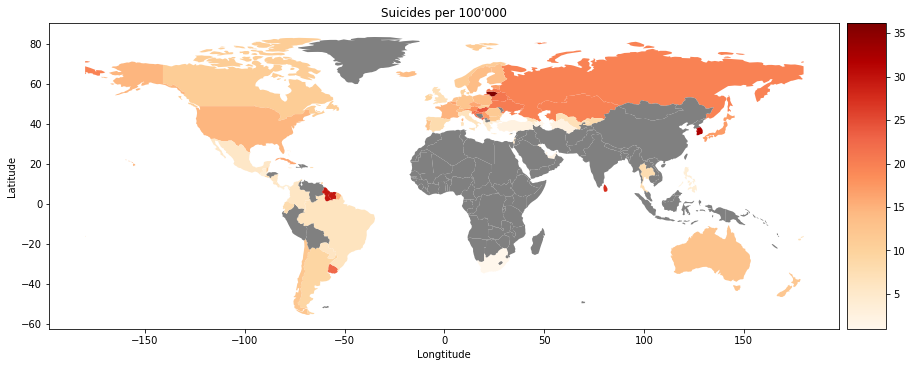

In [11]:
fig, ax = plt.subplots(1, 1)
ax.figure.set_size_inches(15,8)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.OrRd
cmap.set_under(color = 'Gray', alpha = 1)


ax.set_title('Suicides per 100\'000')
ax.set_ylabel('Latitude', fontsize=10)
ax.set_xlabel('Longtitude', fontsize=10)
world[world.name=='Ukraine']['suicides'] = 1000
world.plot(column='suicides',ax=ax, legend=True, cax=cax, cmap=plt.cm.OrRd);

### Insights:
- Not much data about countries in Africa/Asia
- Post-Soviet countries have very high suicide rate

### Global trends

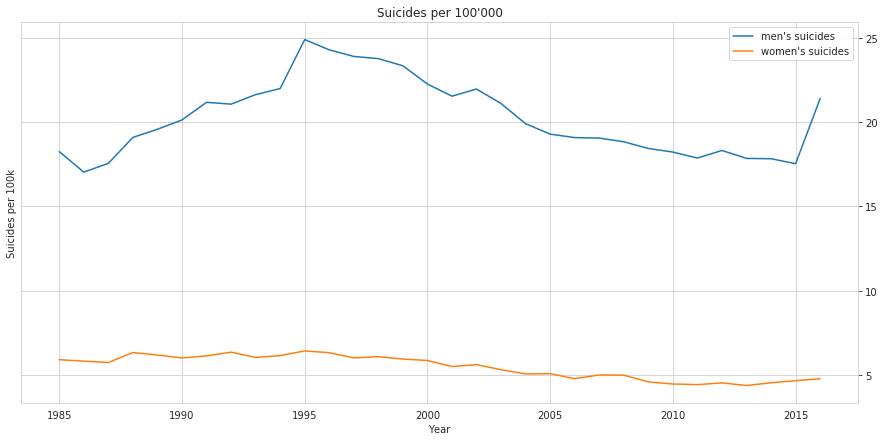

In [12]:
male_total = df[df['sex']=='male'].groupby(['year'])['suicides'].mean().values
female_total = df[df['sex']=='female'].groupby(['year'])['suicides'].mean().values

years = list(range(1985, 2017))

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 1)

ax.figure.set_size_inches(15,7)
ax.set_title('Suicides per 100\'000')
ax.set_xlabel('Year', fontsize=10)
ax.set_ylabel('Suicides per 100k', fontsize=10)

sns.lineplot(x=years,y=male_total, ax=ax)
sns.lineplot(x=years,y=female_total, ax=ax);
ax.legend(['men\'s suicides','women\'s suicides']);
ax.yaxis.tick_right()

### Insights:
- Men's suicide rate is always 3-4 times bigger than woman's.
- Post-Soviet countries have very high suicide rate.
- From the 2015 men's suicides rate increased much

In [13]:
# Calculate mean suicides rate for every country/year
grouped_suicides = df.groupby(['country', 'year', 'sex'])['suicides'].mean()

In [14]:
d = defaultdict(dict)
for (country, year, sex), suicides in grouped_suicides.to_dict().items():
    d[country]['country'] = country
    if not suicides:
        continue
    if sex=='male':
        if d[country].get('male_year', 0) < year:
            d[country]['male_year'] = year
            d[country]['male_suicides'] = suicides
            d[country]['country'] = country
    else:
        if d[country].get('female_year', 0) < year:
            d[country]['female_year'] = year
            d[country]['female_suicides'] = suicides
            
data = pd.DataFrame(list(d.values()), columns=['country', 'male_suicides', 'female_suicides'])
data['total_suicides'] = (data['male_suicides'] + data['female_suicides'])/2
data['male_suicides_part'] = data['male_suicides']/2
data = data.sort_values('total_suicides', ascending=False).reset_index()

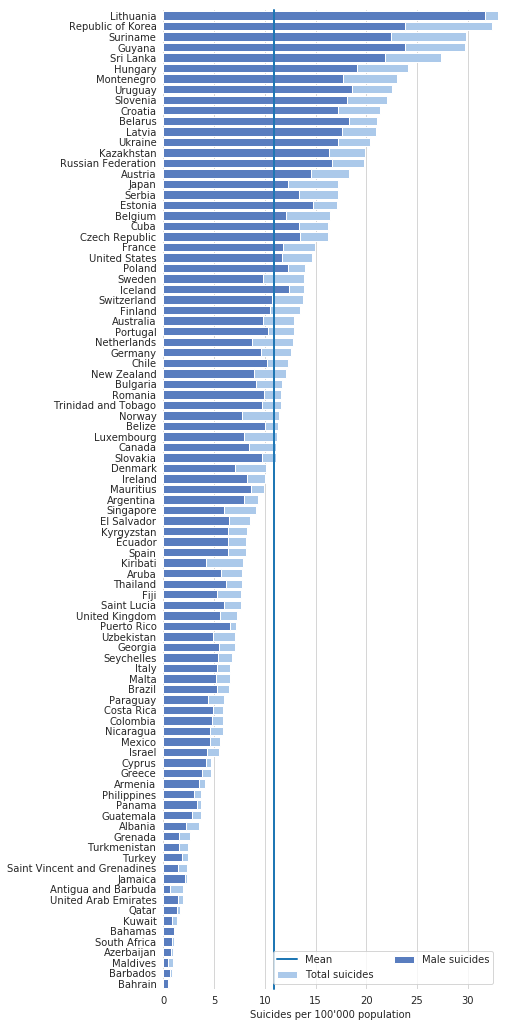

In [15]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 18))

sns.set_color_codes("pastel")
sns.barplot(x="total_suicides", y="country", data=data, label="Total suicides", color="b")

# # Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="male_suicides_part", y="country", data=data, label="Male suicides", color="b")
plt.axvline(x=data['total_suicides'].mean(), lw=2, clip_on=False, label='Mean')

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 33), ylabel="", xlabel="Suicides per 100'000 population")
sns.despine(left=True, bottom=True)

### Insights:
- Ukraine is amongst countries with highest suicide rate
- Japan is the country of G7 with the highest suicide rate
- Small hot islands usually have low rate
- Most of the developed countries have suicide rate above mean

### Inspect GDP (per capita) and suicides correlation

In [16]:
countries_gdp_dict = {}
countries_gdp = df \
  .sort_values('year', ascending=False).reset_index().groupby('country').head(1)[['country', 'gdp_per_capita']]
for country, gdp_per_capita in countries_gdp.values:
    countries_gdp_dict[country] = gdp_per_capita
    
data['gdp_per_capita'] = data.country.map(lambda country: countries_gdp_dict[country])

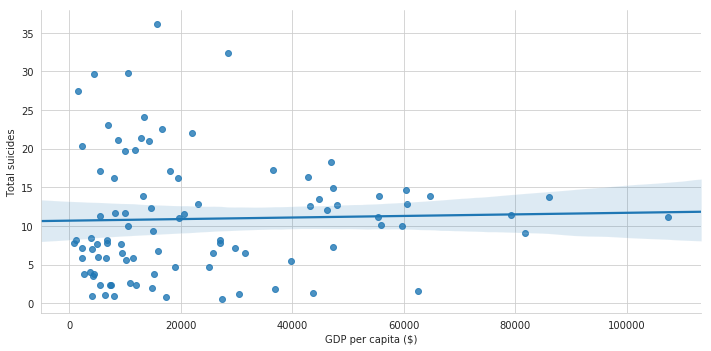

In [17]:
g = sns.lmplot(x='gdp_per_capita', y='total_suicides', data=data, size=5, aspect=2)
g.set_axis_labels('GDP per capita ($)', 'Total suicides');

### There is no significant correlation between `gdp per capita` and `suicides rate`

### Investigate suicides according to age groups 

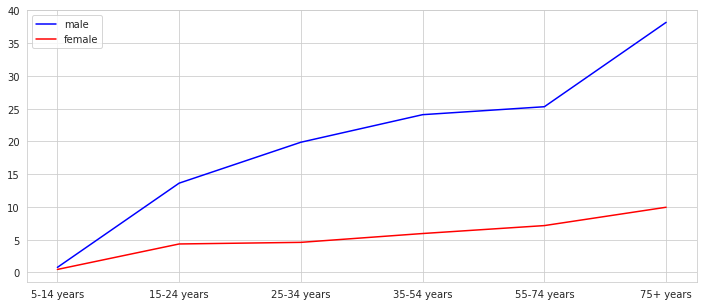

In [18]:
male_by_age = df[df['sex']=='male'].groupby(['age'])['suicides'].mean()
female_by_age = df[df['sex']=='female'].groupby(['age'])['suicides'].mean()
sns.set_style("whitegrid")
age_groups = ['5-14 years', '15-24 years', '25-34 years', '35-54 years','55-74 years', '75+ years']

fig, ax = plt.subplots(figsize=(12,5))

sns.lineplot(x=age_groups, y=[male_by_age[group] for group in age_groups], label='male', ax=ax, 
             sort=False, color='blue');
sns.lineplot(x=age_groups, y=[female_by_age[group] for group in age_groups], label='female', ax=ax,
             sort=False, color='red');

### Insights:
- Suicide in early age is very uncommon act
- Most of the suicides are done by people of the middle age and seniors